# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


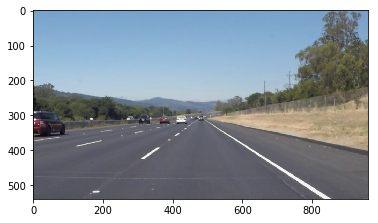

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['whiteCarLaneSwitch.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteRight.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
def process_image_pipeline(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    #convert the image to grayscale
    gray_image = grayscale(image)

    #Blur the image using Gaussian smoothing to reduce noise
    kernel_size = 5
    blur_image = gaussian_blur(gray_image,kernel_size)

    #Using Canny algo detect the edges.
    low_threshold = 50
    high_threshold = 150
    edges_image = canny(blur_image,low_threshold,high_threshold)

    #Indentify the area in the image which is of interest and mask the the rest
    imshape = image.shape
    vertices = np.array([[(imshape[0]*.1,imshape[0]),(430, 330), (520, 330), (imshape[1]*.9,imshape[0])]], dtype=np.int32)
    masked_image = region_of_interest(edges_image, vertices)

    #Tranform from image space to feature space using hough transformation
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 15 #minimum number of pixels making up a line
    max_line_gap = 150 # maximum gap in pixels between connectable line segments

    hough_image = hough_lines(masked_image, rho, theta, threshold, min_line_length, max_line_gap)

    #Draw the lines detected by the hough transformation onto the original image
    result = weighted_img(hough_image, image)
    return result

### Process all the images
for file_name in os.listdir('test_images/'):
    print("\nProcessing ",file_name)
    image = mpimg.imread('test_images/'+file_name)
    print('This image is: ',type(image), 
             'with dimensions:', image.shape)
    final_image = process_image_pipeline(image)
    mpimg.imsave('test_images_output/'+file_name[:-4]+"_final.png", final_image)


Processing  whiteCarLaneSwitch.jpg
This image is:  <class 'numpy.ndarray'> with dimensions: (540, 960, 3)

Processing  solidYellowLeft.jpg
This image is:  <class 'numpy.ndarray'> with dimensions: (540, 960, 3)

Processing  solidYellowCurve2.jpg
This image is:  <class 'numpy.ndarray'> with dimensions: (540, 960, 3)

Processing  solidWhiteCurve.jpg
This image is:  <class 'numpy.ndarray'> with dimensions: (540, 960, 3)

Processing  solidYellowCurve.jpg
This image is:  <class 'numpy.ndarray'> with dimensions: (540, 960, 3)

Processing  solidWhiteRight.jpg
This image is:  <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    #Blur the image using Gaussian smoothing to reduce noise
    
    #convert the image to grayscale
    gray_image = grayscale(image)
    
    kernel_size = 5
    blur_image = gaussian_blur(gray_image,kernel_size)

    #Using Canny algo detect the edges.
    low_threshold = 50
    high_threshold = 150
    edges_image = canny(blur_image,low_threshold,high_threshold)

    #Indentify the area in the image which is of interest and mask the the rest
    imshape = image.shape
    vertices = np.array([[(imshape[0]*.1,imshape[0]),(430, 330), (520, 330), (imshape[1]*.9,imshape[0])]], dtype=np.int32)
    masked_image = region_of_interest(edges_image, vertices)

    #Tranform from image space to feature space using hough transformation
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 15 #minimum number of pixels making up a line
    max_line_gap = 150 # maximum gap in pixels between connectable line segments

    hough_image = hough_lines(masked_image, rho, theta, threshold, min_line_length, max_line_gap)

    #Draw the lines detected by the hough transformation onto the original image
    result = weighted_img(hough_image, image)
    return result

Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:12<00:00, 17.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 1.91 s, sys: 233 ms, total: 2.14 s
Wall time: 14.1 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

In [10]:
##Create new draw_line function to extrapolate the lines
def draw_lines(img, lines, color=[255, 0, 0], thickness=15):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    #Return if lines is empty to handle nonetype error
    if lines is None:
        return
    
    #Initialize the list for storing the slope and intercepty values for left and right lanes
    left_line_b  = []  #List to hold intercept values of left lane lines
    left_line_m  = []  #List to hold slope values of right lane lines
    right_line_b = []  #List to hold intercept values of right lane lines
    right_line_m = []  #List to hold slope values of right lane lines
    

    for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                
                #Ignore the vertical lines
                if x1 == x2:
                    continue
                
                #Get the slope and intercept
                m = (y2-y1)/(x2-x1)
                b = y1 - m*x1
                
                # threshold to check for outliers
                if m >= 0 and (m < 0.1 or m > 0.9):
                    continue
                elif m < 0 and (m < -0.9 or m > -0.1):
                    continue
                    
                # threshold to check for outliers
                if m < 0:
                    left_line_m.append(m)
                    left_line_b.append(b)
                else:
                    right_line_m.append(m)
                    right_line_b.append(b)

    #Take the average
    left_line_b_mean  = np.nanmean(left_line_b)
    left_line_m_mean  = np.nanmean(left_line_m)
    right_line_b_mean = np.nanmean(right_line_b)
    right_line_m_mean = np.nanmean(right_line_m)

    #Y values same for both left and rigth
    imshape = image.shape
    y1 = int(imshape[0])
    y2 = 330 #Same value which is given in ROI function

    print(left_line_b_mean,left_line_m_mean,right_line_b_mean,right_line_m_mean)
    #Calculare x values for left & right lanes
    if (left_line_b_mean==left_line_b_mean and left_line_m_mean==left_line_m_mean):
        x1_left = int((y1 - left_line_b_mean)/left_line_m_mean)
        x2_left = int((y2 - left_line_b_mean)/left_line_m_mean)
    else:
        return
        
    if (right_line_b_mean==right_line_b_mean and right_line_m_mean==right_line_m_mean):
        x1_right = int((y1 - right_line_b_mean)/right_line_m_mean)
        x2_right = int((y2 - right_line_b_mean)/right_line_m_mean)
    else:
        return
        
    ###Draw the left and right lanes on the original image
    cv2.line(img, (x1_left, y1), (x2_left, y2), color, thickness)
    cv2.line(img, (x1_right, y1), (x2_right, y2), color, thickness)

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [11]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

607.396738547 -0.613427603671 -20.1211825548 0.673915651133
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  1%|          | 5/682 [00:00<00:15, 42.51it/s]

607.396738547 -0.613427603671 -20.1211825548 0.673915651133
608.577992852 -0.610831832162 -30.3732611943 0.684775873036
612.015648876 -0.625391044196 -37.8898050576 0.698760521061
622.356508713 -0.646285285926 -19.8362699232 0.67082928502
615.366830419 -0.63192292129 -12.0306637589 0.662008094391
619.636126006 -0.637511564669 -33.1043739236 0.693345743498
621.421545025 -0.64061102976 -11.4107580706 0.656315624026
621.208627184 -0.641306020174 -15.5029199539 0.661312994709
624.95453443 -0.650210000291 -13.0796105711 0.656993848427


  2%|▏         | 15/682 [00:00<00:15, 43.03it/s]

621.285901155 -0.587353760601 -9.77400522215 0.649534269017
619.968030636 -0.641587768835 2.11254176725 0.631559191982
627.351074739 -0.666601575497 -8.80819047263 0.647474073035
627.198708232 -0.661134263781 -6.39812286938 0.643046531737
631.822443197 -0.666732622274 -11.8830284355 0.652914296971
635.544274268 -0.676998838338 -22.3934110446 0.667575829569
639.764354938 -0.688978356201 -0.864817903756 0.633692995001
637.398325339 -0.687665532677 5.55148265989 0.628192045251
640.634886376 -0.691112914313 1.83702325581 0.633302325581


  4%|▎         | 25/682 [00:00<00:15, 43.39it/s]

638.864668854 -0.687179576183 -22.0377236347 0.671551318267
637.293338767 -0.685748669751 -7.67177213058 0.64823118123
637.833841457 -0.688699718712 -9.07157894737 0.649633173844
634.316887403 -0.683366715769 -9.48526589912 0.648780153509
633.769185124 -0.68204654387 -7.26153846154 0.646153846154
633.802724021 -0.682505735418 -10.3105682951 0.649800598205
635.791795664 -0.684259029983 0.340673718006 0.633621394314
640.060615145 -0.689806458614 -16.7770374447 0.660776831097
640.988979337 -0.689521113607 8.56669260709 0.62187517138


  5%|▍         | 34/682 [00:00<00:15, 42.72it/s]

651.360855629 -0.720641152083 5.233497559 0.62543125333
638.368035463 -0.691006287214 3.22471910112 0.625468164794
638.699186646 -0.690884969034 -1.04420731707 0.629573170732
635.348830448 -0.683126208774 nan nan
647.55310325 -0.7165855262 nan nan
651.161918386 -0.721298381786 nan nan
650.74692568 -0.721626470411 nan nan
650.727570673 -0.713539497744 85.0158730159 0.525793650794
662.343680951 -0.756030555392 5.76 0.62


  6%|▌         | 39/682 [00:00<00:14, 42.90it/s]

657.156377144 -0.743123504243 12.71875 0.609375
652.923976774 -0.73144020288 6.11368382023 0.618699139395
648.51287587 -0.72327576586 7.35514018692 0.616822429907
650.321085246 -0.729874364565 16.0550458716 0.605504587156
645.40857793 -0.719514204452 17.6936936937 0.603603603604
649.794534244 -0.726454905066 3.01049475262 0.621939030485
650.59035374 -0.73038012956 nan nan


  6%|▋         | 44/682 [00:01<00:22, 28.70it/s]

649.980766351 -0.728367393119 nan nan
654.427901244 -0.736601151567 11.7222222222 0.611111111111
651.146073374 -0.733320146483 15.0454545455 0.607142857143


  7%|▋         | 48/682 [00:01<00:29, 21.76it/s]

652.749034131 -0.734889864821 -9.99826285487 0.647570478459
647.979324619 -0.722608083419 -7.14285714286 0.642857142857
651.624180607 -0.731389560989 -10.5515981735 0.646093353628
653.333477053 -0.741964076558 19.3768608048 0.602173510533


  7%|▋         | 51/682 [00:01<00:31, 19.79it/s]

649.546516407 -0.726467189408 4.33482142857 0.622767857143
647.316104267 -0.722161600975 4.48342413376 0.623213608748
646.751647893 -0.720960526702 5.3886562619 0.622430529121
651.908332318 -0.732134543916 7.12999870704 0.617025097991


  8%|▊         | 57/682 [00:02<00:36, 17.19it/s]

655.437107171 -0.739755032519 5.62597373735 0.623626002841
647.946048039 -0.719686271459 8.6303445413 0.619897606199
649.457305503 -0.727413488819 -6.83047619048 0.645396825397
650.642349274 -0.72851314018 -6.51327433628 0.646017699115


  9%|▉         | 61/682 [00:02<00:40, 15.44it/s]

650.317708986 -0.729403802001 13.8209098243 0.610756908437
647.033501111 -0.713393182816 77.0981889226 0.535494497057
648.384700333 -0.714281858045 -8.35957167319 0.648796281851


  9%|▉         | 63/682 [00:02<00:40, 15.25it/s]

642.575432252 -0.711882722424 14.4071963128 0.610072172365
640.881573258 -0.708285582271 13.5925257732 0.614518900344
639.640815407 -0.702291259491 7.03815656028 0.623345850398
641.195404475 -0.708509392464 2.07724104973 0.633471586868


 10%|▉         | 67/682 [00:02<00:39, 15.46it/s]

636.531987763 -0.693328527976 8.56685019794 0.619660538176
643.851688537 -0.712999473944 6.80153291964 0.622552541277
638.218926681 -0.695296790815 25.3218251746 0.595018963632


 10%|█         | 71/682 [00:03<00:40, 15.06it/s]

641.497386248 -0.707368613471 19.9916666667 0.602777777778
647.893312263 -0.720366976581 3.25166742415 0.629514674402
641.729705938 -0.705179505755 3.56930475802 0.629030392817
646.245840365 -0.714276786746 127.735541707 0.473650113599


 11%|█         | 75/682 [00:03<00:41, 14.67it/s]

638.915255886 -0.693766745638 1.30038342032 0.633980176934
645.540110875 -0.707556517128 6.76684733154 0.625221105395
644.596132647 -0.710810985933 14.9123160942 0.611680302557


 11%|█▏        | 77/682 [00:03<00:40, 15.03it/s]

643.53054031 -0.706655642223 -1.21368869333 0.637597718079
645.468359102 -0.710388835187 18.4486191026 0.61067141001
643.600418788 -0.710949941024 10.3168916221 0.623795062978
642.532438969 -0.707940775313 19.709908894 0.605066347179


 12%|█▏        | 81/682 [00:03<00:40, 14.79it/s]

656.331823017 -0.737984688395 9.84496279646 0.618900734411
645.082098581 -0.717265967095 6.41432931198 0.626092373533
641.859946465 -0.709035513509 -10.6324603175 0.653686067019
639.643630493 -0.709053085138 -11.3625836721 0.656694109075


 12%|█▏        | 85/682 [00:03<00:39, 15.14it/s]

640.278575573 -0.707973777908 -7.6995249565 0.650060550279
639.852534699 -0.701564940765 6.43912359227 0.625765743741
636.862991142 -0.695533223244 2.6819009477 0.631817211245
637.804507794

 13%|█▎        | 89/682 [00:04<00:40, 14.76it/s]

 -0.697534435067 13.8829861791 0.615434121028
631.505287881 -0.683538461822 -5.28216765556 0.643759293585
634.702418131 -0.688817324635 11.5231518755 0.619208630852


 13%|█▎        | 91/682 [00:04<00:40, 14.71it/s]

634.731277151 -0.687490284787 -1.72560739925 0.640023996378
636.96676543 -0.691003240347 0.394510591867 0.636813311886
636.756599224 -0.688864687398 1.78421071408 0.63608900647


 14%|█▍        | 95/682 [00:04<00:39, 15.04it/s]

637.341498859 -0.686362548 8.55501427877 0.626386612783
635.320100279 -0.637433889949 -3.76518705669 0.65033714148
639.42738741 -0.689177533515 4.57181238604 0.632980737512
638.7449595 -0.686633216202 -11.8493452286 0.662279806771


 15%|█▍        | 99/682 [00:04<00:39, 14.88it/s]

640.632788177 -0.691069240672 2.56603498093 0.636712349867
641.566784478 -0.692891880072 -2.63190760495 0.64822289
647.345515967 -0.711557910231 -3.03124804744 0.643613421819


 15%|█▍        | 101/682 [00:05<00:38, 14.96it/s]

646.511031509 -0.709339688147 -8.86919231663 0.653702980257
642.350186024 -0.694361151672 2.1799497921 0.636247597975
640.894032565 -0.694914705429 2.18028001706 0.634543563527
640.602791009 -0.690356216285 49.6733244389 0.57739853125


 15%|█▌        | 105/682 [00:05<00:39, 14.69it/s]

637.608821501 -0.688187557309 -2.2020678119 0.642628926122
633.400305143 -0.679216897493 2.86716556042 0.631244301469
642.983624737 -0.695077647895 2.20680594109 0.634352718256


 16%|█▌        | 109/682 [00:05<00:39, 14.44it/s]

626.2826244 -0.660922701102 -0.605646272537 0.638394359198
638.171580554 -0.688806110293 -4.70807150398 0.64562355637
639.754156652 -0.694044225822 -2.45273504563 0.643111682343
636.853689755 

 16%|█▋        | 111/682 [00:05<00:38, 14.80it/s]

-0.687177743978 -12.0097525354 0.659485507981
634.980605636 -0.640230113176 1.55596662487 0.637362466913
638.587100303 -0.688775912196 -10.1868795817 0.656915632025
639.061551995 -0.687577273179 2.31999403721 0.634517953945


 17%|█▋        | 115/682 [00:06<00:38, 14.77it/s]

637.647803782 -0.686358786176 9.8406454145 0.621435182108
642.110222145 -0.697657178801 -1.60665636625 0.640570275664
636.516300334 -0.682903995729 13.3877270848 0.615235071111


 17%|█▋        | 119/682 [00:06<00:38, 14.69it/s]

640.516267596 -0.691551671104 1.97853636503 0.631551107181
637.218933354 -0.685052871886 2.48559154468 0.632284655989
639.993909713 -0.690722935846 -3.16101530946 0.637700835116
639.348881628 -0.687195401114 5.94177871961 0.626418163509


 18%|█▊        | 121/682 [00:06<00:38, 14.67it/s]

639.988386956 -0.692541963077 -0.105604078733 0.637526731268
644.379115399 -0.70601000618 5.96494609708 0.627573946257
645.097421452 -0.708604207432 3.88282087033 0.634735301755


 18%|█▊        | 125/682 [00:06<00:38, 14.65it/s]

645.462525897 -0.708722457932 -2.18332877832 0.639685238824
644.691001348 -0.707008853171 0.798055140995 0.634960364456
646.326013605 -0.709085686988 -0.0120968702635 0.636633495251
643.298531304 -0.703277003695 6.66473888339 0.625393391616


 19%|█▉        | 129/682 [00:06<00:37, 14.82it/s]

646.189537631 -0.706102065304 11.7127980303 0.618998152155
643.786505521 -0.695094317393 2.91990641302 0.631349551844
645.361521269 -0.702218350942 17.9650295986 0.60879913507
640.855966626 -0.688876652349 -0.19536834887 0.634104791797


 20%|█▉        | 133/682 [00:07<00:36, 14.90it/s]

643.07545085 -0.695216727547 12.2859041731 0.616664543198
643.730960196 -0.697236825577 5.99174083378 0.626518596303
641.966279293 -0.691597632877 2.58210804932 0.633401295148


 20%|██        | 137/682 [00:07<00:36, 14.91it/s]

645.626530876 -0.701664047849 6.49777494065 0.625409610605
644.446258262 -0.70141139563 -1.51287705835 0.64053303736
645.268651437 -0.697582273684 4.32300196784 0.63102448462
646.088022528 -0.700160744003 0.808192947797 0.635739582509


 21%|██        | 141/682 [00:07<00:36, 14.79it/s]

645.912656066 -0.700441880178 14.6954382371 0.612973314452
648.07085492 -0.706285515294 -2.25917039666 0.638508539072
642.028913094 -0.692851610601 13.3692922087 0.617734276407


 21%|██        | 143/682 [00:07<00:36, 14.89it/s]

645.763306596 -0.698156255932 24.0019754491 0.599878628834
642.716359727 -0.694981408473 13.3874316715 0.616239837534
638.483922814 -0.684002598968 6.58787883428 0.627745005753
641.167420111 -0.688924135318 2.00814322628 0.633876891842


 22%|██▏       | 147/682 [00:08<00:35, 15.07it/s]

650.058813331 -0.711597367226 -0.736563415183 0.639342761253
650.215059214 -0.711263381646 6.19531462887 0.627163544872
646.544579726 -0.708652900046 -0.0181760764241 0.638172751421
645.894477485 -0.701090943346 -0.996851352108 0.637756642573


 22%|██▏       | 151/682 [00:08<00:36, 14.74it/s]

631.845293569 -0.66868421382 -1.11496794789 0.63808820122
650.518750601 -0.710155777448 16.7178488999 0.610386006227
650.191574084 -0.708259911975 19.0523540159 0.60612931854
651.756145638 -0.71170523411 6.05266606782 0.626802445327


 23%|██▎       | 155/682 [00:08<00:34, 15.13it/s]

651.840872563 -0.710072468569 26.6851203084 0.591679827285
649.247877541 -0.702988803479 12.5137215436 0.615237759037
653.279415469 -0.708872937593 -0.0799283423628 0.632390355705
636.763965885 -0.662296432226 24.71498711 0.595974480013


 23%|██▎       | 159/682 [00:08<00:35, 14.91it/s]

654.690763765 -0.708677134057 18.0035519729 0.608540848742
653.28957046 -0.705068965622 21.6097272864 0.603157939205
650.474653515 -0.697301765454 22.6245396217 0.600091175509


 24%|██▍       | 163/682 [00:09<00:36, 14.12it/s]

654.766159138 -0.718590702066 71.7991187579 0.541220084639
661.931682191 -0.729203522915 15.2066494052 0.61247513978
654.370511446 -0.705153830635 7.32278071921 0.62428205604


 24%|██▍       | 165/682 [00:09<00:36, 14.13it/s]

650.863814139 -0.705929798267 22.2178299341 0.60016230164
650.122129198 -0.700417034272 23.483495835 0.598085725856
654.206599976 -0.710522598481 24.4533394608 0.596131509059


 25%|██▍       | 169/682 [00:09<00:37, 13.70it/s]

656.305449474 -0.714234835184 16.898459909 0.606995498574
657.142363397 -0.713373793908 22.7111466326 0.599286018755
657.231223864 -0.713549880268 20.944510978 0.599201596806


 25%|██▌       | 171/682 [00:09<00:36, 13.90it/s]

659.329086344 -0.716354088102 19.8954073666 0.600707265546
664.204242114 -0.730228418346 20.8464025386 0.600002094592
657.93907304 -0.713051011375 15.799503773 0.607403306358
663.045854261 -0.720883747924 20.9275196086 0.599733792219


 26%|██▌       | 175/682 [00:10<00:35, 14.44it/s]

668.217059577 -0.735460909606 21.2309992244 0.598039898785
668.446485643 -0.740897416727 31.741907298 0.578180910377
676.503434753 -0.757326085994 34.6323529412 0.573529411765


 26%|██▌       | 179/682 [00:10<00:34, 14.60it/s]

670.958448494 -0.748966113049 46.5 0.552631578947
675.112798432 -0.756051390345 46.6140565317 0.550114591291
675.245727602 -0.760979734032 56.6236263736 0.534340659341
681.271121412 -0.768598968046 45.7755972542 0.553840523704


 27%|██▋       | 183/682 [00:10<00:34, 14.42it/s]

672.34173942 -0.74995361138 48.5616970926 0.54783637593
670.251015259 -0.744909511784 34.2743658211 0.575433911883
676.756352184 -0.766332945885 34.7484491315 0.574751861042
673.690910457 -0.75170557557 42.2560634328 0.559878731343


 27%|██▋       | 187/682 [00:10<00:34, 14.21it/s]

678.717454567 -0.766211755037 35.8394719614 0.572584632613
667.880575534 -0.737827122664 40.3409017827 0.564737690215
677.242697476 -0.763155043998 47.6621696084 0.552268859205


 28%|██▊       | 189/682 [00:11<00:34, 14.39it/s]

679.644871291 -0.76676466374 36.549523953 0.572784076387
677.764126098 -0.761317949906 35.5585143967 0.574661326089
677.543697179 -0.760108911664 32.2799006376 0.580717461415


 28%|██▊       | 193/682 [00:11<00:35, 13.77it/s]

679.925148871 -0.767615317238 41.3278799762 0.564423883485
669.708720583 -0.743077953496 39.2589412302 0.569551104965
678.950171318 -0.769275075553 32.1827972659 0.58148146407


 29%|██▊       | 195/682 [00:11<00:35, 13.84it/s]

678.897613478 -0.76702159684 41.2664659415 0.56519036519
689.002556628 -0.802078456307 42.8048571385 0.561007034017
677.151464841 -0.76884129779 36.0006527625 0.573873822198
677.937746174 -0.767758859897 53.3050200065 0.541210765929


 29%|██▉       | 199/682 [00:11<00:33, 14.26it/s]

675.997559898 -0.766242414794 41.4120671525 0.565792808569
675.600226841 -0.766354580497 39.237858682 0.570981790148
675.832955915 -0.771588251807 42.0580034973 0.56567207433
679.081148417 -0.774927153483 43.288466466 0.564668591231


 30%|██▉       | 203/682 [00:12<00:32, 14.70it/s]

673.475418205 -0.765208029112 20.3484841045 0.600339409941
672.657516974 -0.763809268598 24.1623439032 0.595840688678
668.022388143 -0.749443676751 27.814113101 0.592171644779
671.303106146 -0.755705494634 43.5745903578 0.56857338389


 30%|███       | 207/682 [00:12<00:32, 14.81it/s]

675.129240264 -0.763984831695 45.4635854865 0.568206135662
671.046944893 -0.755641403345 43.5113311655 0.568496797771
677.941747625 -0.77019589631 47.0224122426 0.559759003856
666.446565113 -0.743702907751 41.314445654 0.570962328638


 31%|███       | 211/682 [00:12<00:32, 14.72it/s]

664.645797369 -0.741138359306 31.1742486229 0.586560118967
665.740883905 -0.741687341074 37.4017873298 0.577495362881
662.193214205 -0.734690519134 28.3341277684 0.593433179704
653.2232023 -0.706730885238 33.2415559901 0.585672834785


 32%|███▏      | 215/682 [00:12<00:30, 15.11it/s]

661.59102017 -0.741012817235 38.7406113698 0.578622101939
657.814276484 -0.726184039332 33.5313258373 0.58720355617
655.805270616 -0.722537036587 29.0545460132 0.596349854539
656.376299162 -0.725768578987 19.5859373178 0.609093216644


 32%|███▏      | 219/682 [00:13<00:30, 15.10it/s]

655.281923239 -0.723736976928 30.7966751103 0.592503844575
655.227576329 -0.724277770666 31.5189774937 0.589631687815
659.292470259 -0.731226929903 31.7925687943 0.589899526241
657.85828096 -0.729961252823 31.5604278638 0.589087381574


 33%|███▎      | 223/682 [00:13<00:30, 15.25it/s]

657.344462055 -0.735331099366 18.9789989303 0.608411678881
656.749250895 -0.727082145084 19.5392427318 0.607697736555
656.966632874 -0.72719729745 31.2846038856 0.588087546504


 33%|███▎      | 227/682 [00:13<00:31, 14.55it/s]

657.814842506 -0.727685580923 34.8686548803 0.582644199909
656.410379601 -0.724572523625 19.949968299 0.604788889146
657.280027474 -0.727285522961 14.5815774213 0.613694523442


 34%|███▎      | 229/682 [00:13<00:30, 14.66it/s]

657.713358034 -0.72966121687 29.4452138022 0.592143411969
658.440128822 -0.732901141823 20.8046924947 0.608630963892
655.83347955 -0.727403277039 20.7258561649 0.60429970742
656.880503825 -0.728179278302 -10.4067002816 0.644472572625


 34%|███▍      | 233/682 [00:14<00:29, 15.16it/s]

651.897025354 -0.713289892135 17.3468968445 0.609486344984
648.966664401 -0.712874553742 19.3276439213 0.606952463904
650.281577529 -0.711330664959 20.7084600741 0.604226217719
648.695608165 -0.709665870713 14.2791766589 0.614875372204


 35%|███▍      | 237/682 [00:14<00:29, 14.99it/s]

648.775594512 -0.711348098453 14.6512062889 0.613079689291
647.888704638 -0.711082737115 -7.66052575863 0.652463924298
647.353684761 -0.709658227132 -7.73840907002 0.650376425211
646.431990878 -0.706933464947 13.2162716605 0.615075485913


 35%|███▌      | 241/682 [00:14<00:30, 14.66it/s]

648.206831313 -0.712845934759 17.1227088184 0.609337972896
647.177559375 -0.709801053106 8.52817925673 0.624240583504
642.546447585 -0.693861604069 19.8676990287 0.603447714473
645.954810198 -0.702771285329 21.9464800362 0.600625956061


 36%|███▌      | 245/682 [00:14<00:29, 14.84it/s]

643.329901714 -0.696149122476 12.5020162928 0.617211035741
643.879225978 -0.695722723505 28.3025117187 0.592087225089
645.795196027 -0.697214613374 35.5384434975 0.579722928461
645.466553128 -0.699561267091 84.2073401509 0.522406088535


 37%|███▋      | 249/682 [00:15<00:30, 14.36it/s]

643.115109013 -0.695218308367 17.575612838 0.611932027929
644.157445718 -0.697448856635 37.2497346626 0.577424679348
653.384811929 -0.714558326337 17.923963679 0.610634117743


 37%|███▋      | 253/682 [00:15<00:29, 14.67it/s]

642.277374766 -0.69337874088 16.3558797367 0.611608427684
645.51174712 -0.699074867533 20.1660528309 0.607834128366
660.889401283 -0.736984389593 20.8482910087 0.607868084059
650.747748763 -0.707363447878 18.8786352116 0.612066064573


 38%|███▊      | 257/682 [00:15<00:30, 14.09it/s]

662.453414407 -0.745009559013 34.5742446574 0.586730325729
659.693945057 -0.736898541635 24.9221438909 0.596903892601
658.608918824 -0.740785216585 14.5127458288 0.614505366397


 38%|███▊      | 259/682 [00:15<00:29, 14.38it/s]

655.177840672 -0.724134214458 23.5616444516 0.603106435178
652.597575177 -0.718581025378 27.7587034614 0.5926522016
652.75350637 -0.71696669518 26.6137808039 0.595865549571
655.513711227 -0.726193444635 24.262971432 0.60010460738


 39%|███▊      | 263/682 [00:16<00:28, 14.61it/s]

660.101727153 -0.733661356479 24.2992123851 0.599624446527
659.938101608 -0.733846872663 25.6971692081 0.594408301726
651.87266671 -0.708694765494 28.4009584207 0.589568199328


 39%|███▉      | 267/682 [00:16<00:28, 14.78it/s]

650.720982758 -0.694919971156 21.6584770323 0.601479598388
650.241047917 -0.709595611903 27.0431906952 0.590816003216
651.659412664 -0.71338782689 19.4352677432 0.604153139606
650.796153544 -0.71296421884 24.2800935138 0.59587801109


 40%|███▉      | 271/682 [00:16<00:27, 14.72it/s]

652.038667641 -0.712292922819 41.6409859971 0.565288705632
651.686046967 -0.716542332456 30.9144635788 0.588008801408
649.910508115 -0.706632375068 51.6948216057 0.545231317698
655.917492398 -0.716395395527 22.4322851582 0.600993029016


 40%|████      | 275/682 [00:16<00:28, 14.52it/s]

653.157516365 -0.713134732991 34.7312402261 0.576428006138
654.898709799 -0.715128446869 35.7790057217 0.575775105329
654.14677237 -0.711074774976 35.4629132795 0.5759164023


 41%|████      | 277/682 [00:17<00:28, 14.05it/s]

652.908444727 -0.711432953541 39.5708957843 0.568545356951
654.679861654 -0.713131713926 23.9460185398 0.596450955945
652.296170071 -0.712368897117 30.7406241514 0.587104043711


 41%|████      | 281/682 [00:17<00:27, 14.55it/s]

607.337725158 -0.601970743872 55.0933440469 0.550092863491
654.400958391 -0.71357508142 21.0056045104 0.602725613391
623.499800982 -0.634683517729 37.4639506782 0.577856466575
658.122716555 -0.719588488834 39.0940373099 0.578210502328


 42%|████▏     | 285/682 [00:17<00:27, 14.23it/s]

655.417979661 -0.711018672136 45.2145869179 0.568242861382
670.987621764 -0.744459684217 46.4324652765 0.565451081088
657.091054427 -0.719157107182 47.2125201783 0.563186086317


 42%|████▏     | 287/682 [00:17<00:27, 14.48it/s]

664.145829788 -0.740067689249 48.2947079115 0.562133061709
662.143161663 -0.736606711953 41.8865890132 0.571516213297
639.292183871 -0.662814201965 38.2940326115 0.582095283064
656.139469817 -0.710235014964 39.3774597545 0.58264758459


 43%|████▎     | 291/682 [00:18<00:27, 14.32it/s]

658.342787892 -0.713187686787 24.3299980012 0.61020061631
656.45552405 -0.714515425916 37.6225720694 0.584358931367
655.547852109 -0.713507687975 111.527398338 0.518696318307


 43%|████▎     | 295/682 [00:18<00:24, 15.58it/s]

656.558178705 -0.714922470266 36.2129502507 0.58509858829
651.249981883 -0.709767445222 7.49244200331 0.634151887461
660.071291919 -0.728697734364 22.8284094993 0.606804442908
660.696972721 -0.731237220367 21.2309914507 0.60906828185


 44%|████▍     | 299/682 [00:18<00:26, 14.59it/s]

659.207013863 -0.7301775984 30.8430003816 0.590027111274
659.680418739 -0.731355425282 11.1124771667 0.622608234601
661.229437366 -0.731778675221 32.6419662073 0.590117783928


 44%|████▍     | 301/682 [00:18<00:26, 14.54it/s]

660.47266272 -0.72411062 22.4142614803 0.606193018655
659.513527273 -0.724626888924 40.7599854781 0.5779359416
657.634957078 -0.720623233469 27.5527237997 0.599284224442
668.952823365 -0.752196061515 28.7144231938 0.594732345581


 45%|████▍     | 305/682 [00:19<00:25, 14.78it/s]

658.570814157 -0.730723398697 28.5446453363 0.594393082622
660.543871838 -0.735540578556 28.6602695641 0.595021114103
656.95008203 -0.7297743705 17.9343214189 0.611465406185
655.728071557 -0.731899927836 11.4497842539 0.621620479709


 45%|████▌     | 309/682 [00:19<00:24, 14.96it/s]

655.829489316 -0.727388727928 18.01182802 0.608599006878
658.794276867 -0.736371172454 16.3621667922 0.609650616777
655.887612725 -0.731126386771 16.8946815464 0.608656891595


 46%|████▌     | 313/682 [00:19<00:26, 14.10it/s]

651.953711487 -0.719582577734 10.5574641284 0.620442857309
651.007227078 -0.717880102812 12.2431142912 0.619270642412
639.946806387 -0.691698895893 14.1606191608 0.615473851662


 46%|████▌     | 315/682 [00:19<00:26, 13.87it/s]

644.513907472 -0.700321653651 16.0195114014 0.611508693127
651.067474351 -0.715925975618 20.7370158503 0.605066421341
650.868856787 -0.715928233448 21.2356822091 0.603778643512


 47%|████▋     | 319/682 [00:20<00:25, 14.05it/s]

648.515809881 -0.710353959783 16.6099671604 0.612729075144
645.444785855 -0.705225801146 17.8094040223 0.610794970939
638.68546677 -0.689671623675 25.787574153 0.595273324534


 47%|████▋     | 321/682 [00:20<00:25, 14.14it/s]

650.007832995 -0.712157147985 40.2125743933 0.572164300375
657.809234265 -0.735202623272 32.0332309451 0.586833616717
651.599001487 -0.717693747182 30.1065547175 0.588765720982
644.696762581 -0.700690013221 26.2337908082 0.594430505058


 48%|████▊     | 325/682 [00:20<00:25, 14.03it/s]

653.506277588 -0.719130420256 29.8077526326 0.588570724431
649.91590958 -0.713644956827 30.4775304082 0.591052672269
649.991151548 -0.718725148641 32.6985690102 0.587797310084


 48%|████▊     | 329/682 [00:20<00:24, 14.49it/s]

648.775141673 -0.71060821207 25.2470473727 0.600609691208
650.581581895 -0.713669184661 22.7442304401 0.606227381545
650.830395782 -0.716800782968 16.1197916565 0.617043786354


 49%|████▊     | 331/682 [00:20<00:24, 14.30it/s]

647.112982746 -0.711226960194 24.240130045 0.608311380958
645.573792071 -0.711611693603 12.6537719948 0.620307078582
645.267430385 -0.711689066363 14.974019903 0.615086486683


 49%|████▉     | 335/682 [00:21<00:24, 14.45it/s]

646.260330344 -0.707818272997 23.9533070065 0.600050700066
646.024051393 -0.706502055076 21.4043886849 0.605404010658
642.120727657 -0.692512470557 18.178600921 0.612984821858


 49%|████▉     | 337/682 [00:21<00:23, 14.42it/s]

641.492887268 -0.685570231502 18.8201463336 0.61282186308
638.858349316 -0.68413180063 19.6901599811 0.609979291013
638.226041128 -0.682368520129 19.1426107757 0.611202335831


 50%|█████     | 341/682 [00:21<00:23, 14.56it/s]

639.207791393 -0.688482604368 27.363333462 0.599111867356
636.338369419 -0.682780991656 20.8662683774 0.609342277631
636.47054666 -0.681996797087 32.9006959019 0.589009352436
629.836905109 -0.668659760386 16.5772926738 0.61575437615


 51%|█████     | 345/682 [00:21<00:23, 14.07it/s]

637.766472629 -0.684620036537 15.7959015379 0.617246205552
636.052861408 -0.681007161616 16.6738970382 0.614449887277
638.598913158 -0.686873013923 19.4045287603 0.610237328067


 51%|█████     | 347/682 [00:22<00:23, 14.29it/s]

638.738501722 -0.685757138713 25.4502274358 0.600198148894
638.182264378 -0.684326651799 15.7587629221 0.615628435677
639.925155904 -0.633889751121 10.6781443384 0.624632647513


 51%|█████▏    | 351/682 [00:22<00:24, 13.61it/s]

640.664269052 -0.685893794847 20.3069289453 0.609249373625
656.217206794 -0.722878445478 18.7908473884 0.610925324314
642.618688617 -0.691059215202 25.3427013019 0.599990591654
641.983755088 -0.690945826091 15.3743211383 0.619001730053


 52%|█████▏    | 355/682 [00:22<00:22, 14.26it/s]

640.999490197 -0.689244123693 8.98974077794 0.624919061678
642.808473709 -0.693340874382 19.9971082885 0.610449908944
630.5020303 -0.658495791757 14.040779467 0.618744587047
645.115466625 -0.698474310173 32.4010213771 0.588461706286


 53%|█████▎    | 359/682 [00:22<00:22, 14.43it/s]

638.348061553 -0.684490136004 33.3940353808 0.586749788682
639.927707554 -0.692439168847 28.1366054784 0.595707721597
637.948186219 -0.685354344171 36.0798483663 0.582828073187
639.435440168 -0.690195967853 30.5924156481 0.590257508727


 53%|█████▎    | 363/682 [00:23<00:21, 14.51it/s]

640.943456448 -0.693490667026 28.1231443027 0.594385095385
647.114322488 -0.709411362597 15.7790096826 0.616796892578
640.220805658 -0.685957733773 20.8259455199 0.605485880185
658.77111373 -0.734545790651 21.222708548 0.60872407145


 54%|█████▍    | 367/682 [00:23<00:21, 14.48it/s]

655.816603591 -0.722945700736 23.2304689615 0.605919602743
635.9416608 -0.682444457941 34.40888441 0.5875502406
642.945961761 -0.698178246927 35.8627063127 0.582222587392
646.702240635 -0.710325005755 37.3259285113 0.580420024648


 54%|█████▍    | 371/682 [00:23<00:20, 14.90it/s]

652.961585163 -0.721587632033 53.2327537683 0.550183937892
641.883856881 -0.698674722569 36.7866736798 0.581718902688
653.077624579 -0.725017658125 34.4599725016 0.586546868896


 55%|█████▍    | 373/682 [00:23<00:20, 14.97it/s]

653.557481059 -0.734772999527 36.0311966435 0.583214320934
651.682223076 -0.722327105317 21.0929048627 0.609721129381
649.878845645 -0.714180223686 22.150359907 0.606763448194
647.880651042 -0.712781724572 21.413902535 0.609355250138


 55%|█████▌    | 377/682 [00:24<00:25, 12.14it/s]

648.227116081 -0.716676143577 20.0982986597 0.614103453847
644.514961492 -0.712301732426 18.3420173634 0.615636963787


 56%|█████▌    | 379/682 [00:24<00:26, 11.41it/s]

643.739719016 -0.713189425882 22.8204701927 0.607468577902
643.637732701 -0.712680471285 14.9589228253 0.617367841466
628.735500709 -0.683506245107 30.0154613687 0.594734080489


 56%|█████▌    | 383/682 [00:24<00:24, 12.40it/s]

640.939457293 -0.706706786077 38.2514727541 0.580444076256
640.927961811 -0.697322493281 20.9568489688 0.611252276608
641.572249908 -0.700987137883 30.3145159288 0.59629601298


 56%|█████▋    | 385/682 [00:24<00:22, 13.04it/s]

641.190436664 -0.702055565955 19.2513754822 0.615110106619
636.964018611 -0.693086136865 26.1585589946 0.602725614959
641.877162955 -0.701795379887 22.6920967288 0.608934888655
640.645107618 -0.700109910206 19.2990043995 0.614597550839


 57%|█████▋    | 389/682 [00:25<00:21, 13.57it/s]

640.592990281 -0.696500662221 19.0413985269 0.613757657464
638.398173715 -0.691628541548 19.5336744115 0.614045474872
628.186612689 -0.666885423904 14.5102700317 0.622162965499


 58%|█████▊    | 393/682 [00:25<00:21, 13.73it/s]

637.971579644 -0.691001876041 10.5311204398 0.629206627414
624.963069312 -0.674244530743 9.64339417006 0.632103802702
635.800485646 -0.686885685138 7.4499528632 0.633703730443


 58%|█████▊    | 395/682 [00:25<00:20, 14.12it/s]

636.541167761 -0.688692277688 13.5952968357 0.623708154257
637.13371747 -0.689183334091 21.5258163406 0.610226765537
636.267749054 -0.687526309508 10.5586575304 0.629644098611
636.036413365 -0.690479134199 5.89875155604 0.637237619668


 59%|█████▊    | 399/682 [00:25<00:19, 14.83it/s]

632.796180925 -0.681953738553 6.74208181662 0.637534966544
629.933363674 -0.670298306392 7.81657185511 0.635910986331
633.46905277 -0.684414691893 9.45880158174 0.633484191749
631.569872087 -0.66511640689 11.1006827327 0.630395074801


 59%|█████▉    | 403/682 [00:26<00:18, 14.69it/s]

631.349225563 -0.67279657 10.3193847105 0.633491432849
631.352994904 -0.672916426355 4.84291709221 0.642729050128
623.069882058 -0.649432402498 10.7902698645 0.634044569303


 60%|█████▉    | 407/682 [00:26<00:18, 14.62it/s]

635.894896887 -0.678124562258 6.66723247899 0.638889326936
652.163287333 -0.717469316032 11.3002296042 0.631052765242
634.035673056 -0.66931760811 12.0035272438 0.62827239975
632.769305295

 60%|█████▉    | 409/682 [00:26<00:18, 14.72it/s]

 -0.674628548726 4.78853658465 0.639345513638
632.60180866 -0.673638480966 6.80969669764 0.63881560631
633.763291878 -0.682211601473 6.5450920508 0.639102670514


 61%|██████    | 413/682 [00:26<00:18, 14.53it/s]

632.75678241 -0.677389014894 -5.40568535979 0.655450850371
632.669229247 -0.680284405096 -2.78238542163 0.649830666659
633.101096379 -0.685741556318 8.81762488715 0.628276812822
634.077836873

 61%|██████    | 415/682 [00:26<00:18, 14.65it/s]

 -0.684044515569 4.41068273599 0.637934398332
634.056856634 -0.68135870745 2.16134319259 0.639379410191
623.521924384 -0.662861872676 13.5534483767 0.620205302931
635.18203257 -0.681573560724 8.82799629587 0.628394104256


 61%|██████▏   | 419/682 [00:27<00:17, 15.23it/s]

637.531569157 -0.685805543452 4.95663382096 0.635524125286
636.654633352 -0.679343120042 14.9615899976 0.620576948787
625.03008853 -0.652201630224 2.43135670524 0.641073356072


 62%|██████▏   | 423/682 [00:27<00:17, 14.48it/s]

634.545653123 -0.520318675288 32.4734040603 0.598721369023
636.728450738 -0.683726240407 10.4748382828 0.626099887985
635.654805382 -0.68423727257 0.517660910518 0.640953689168


 62%|██████▏   | 425/682 [00:27<00:17, 14.63it/s]

634.357876352 -0.681288337064 11.2178298202 0.6243294176
631.84612911 -0.66941476623 23.6939565806 0.609009108308
639.013701803 -0.687006469703 1.39988516516 0.638964030066
624.058211021 -0.623636666035 8.4470394058 0.629488686845


 63%|██████▎   | 429/682 [00:27<00:16, 15.05it/s]

625.267066364 -0.661304965242 -2.60487303708 0.648268750252
637.308767609 -0.684359757518 17.8600608972 0.61307525737
637.466306472 -0.687643928377 2.87381556786 0.63818404795


 63%|██████▎   | 433/682 [00:28<00:17, 14.50it/s]

639.973875404 -0.691953821105 -7.87496512833 0.654845169775
636.756485315 -0.685357778325 0.690040743311 0.643379995988
637.598534132 -0.6861685987 7.15182107193 0.630378859806
628.913916458

 64%|██████▍   | 435/682 [00:28<00:17, 14.24it/s]

 -0.666498010919 11.9660722056 0.623710168681
629.786281663 -0.668116659034 -11.7743739569 0.660710634698
635.884835255 -0.682810218733 7.59097957626 0.631461434385
635.538147056 -0.685016037097 -14.0480120078 0.665147353144


 64%|██████▍   | 439/682 [00:28<00:16, 14.63it/s]

636.368838334 -0.685593828521 3.88519348515 0.634105924725
635.353267511 -0.684730850022 43.345297293 0.590071489135
619.914121736 -0.657427966538 67.307251954 0.561197307711
618.192526267 -0.653080901247 1.05244812427 0.637282549173


 65%|██████▍   | 443/682 [00:28<00:15, 15.08it/s]

627.778417485 -0.662886061354 17.9496903683 0.609485798553
633.126038423 -0.683874656104 8.32662609721 0.628023392729
632.533593322 -0.682773270363 13.883461879 0.618983978176
632.860701382 -0.682184176308 -2.99414363382 0.645642483893


 66%|██████▌   | 447/682 [00:29<00:15, 14.78it/s]

632.400810669 -0.618616613907 2.54852323375 0.642072575382
634.819881839 -0.687039509893 5.51766319138 0.636491994881
644.22787509 -0.712057517063 4.63075955178 0.634098784735
631.257869176 -0.680879109497 8.76598193712 0.630959107677


 66%|██████▌   | 451/682 [00:29<00:15, 14.86it/s]

632.997292178 -0.68763109223 -1.04894848506 0.642279006543
632.593012892 -0.68516100356 17.099136714 0.613945736903
633.20944192 -0.687513760571 3.23963687325 0.63693851904
619.159435802 -0.658273460601 1.52624746402 0.639224623799


 67%|██████▋   | 455/682 [00:29<00:15, 15.02it/s]

627.156272706 -0.671370091249 9.07027543571 0.625156205225
634.845870903 -0.692000985644 3.73756008679 0.630654838416
620.687928214 -0.647658552423 4.36166339105 0.631327564101
630.704234073 -0.678264201817 1.68940149656 0.636234709636


 67%|██████▋   | 459/682 [00:29<00:15, 14.85it/s]

628.954776867 -0.667298348099 2.42350603243 0.638155854323
631.151292933 -0.66686241642 3.07590398218 0.638203672663
625.597496982 -0.653217421847 3.24341208138 0.635342990125


 68%|██████▊   | 463/682 [00:30<00:15, 14.45it/s]

628.922812291 -0.660918266218 -1.12251997958 0.641687223841
632.391428606 -0.679647575839 6.13433075593 0.629629276427
630.368331951 -0.672869936207 8.47391819364 0.624173624954


 68%|██████▊   | 465/682 [00:30<00:15, 14.10it/s]

633.272842994 -0.6808760729 2.87896208248 0.634173689018
630.401947297 -0.680279071913 5.51394249181 0.629057310634
636.925612436 -0.687907543461 19.9107696632 0.606571375249
632.311961021 -0.6746313673 23.9928617571 0.600100699194


 69%|██████▉   | 469/682 [00:30<00:14, 14.47it/s]

639.252013667 -0.690636783792 14.7715554935 0.614203404009
631.113478514 -0.672166121678 16.8466470782 0.611017827666
633.3779352 -0.67547574353 17.0552117603 0.614249015511
636.548043561 -0.621897047829 13.9924606537 0.620675921033


 69%|██████▉   | 473/682 [00:30<00:14, 14.83it/s]

637.434593611 -0.684114774362 14.4107258047 0.620291360911
633.951052703 -0.668974114392 6.02300464033 0.634028841294
635.549709387 -0.669985173978 4.36554083209 0.635928043986
633.453891533 -0.672009939346 11.0885202421 0.624271652896


 70%|██████▉   | 477/682 [00:31<00:13, 14.90it/s]

634.33930942 -0.67510080042 6.93390661829 0.632413236269
635.047088822 -0.675981909117 4.52730489802 0.635833212446
634.331638158 -0.673340614825 21.685246613 0.611338928157


 71%|███████   | 481/682 [00:31<00:13, 14.71it/s]

637.680501968 -0.687751870583 13.4956201082 0.622973517046
639.185328801 -0.683992806382 19.052506575 0.61219465649
641.663838972 -0.689875136185 9.47844730136 0.628425792409
636.765339399 

 71%|███████   | 483/682 [00:31<00:13, 14.97it/s]

-0.678224426586 0.839253630882 0.643897026993
640.040886482 -0.68490699817 -3.34717677153 0.649539105258
643.51636948 -0.690447996724 15.7811428837 0.618030179014
641.164723832 -0.691159995232 -8.21594461623 0.658257476166


 71%|███████▏  | 487/682 [00:31<00:13, 14.61it/s]

639.53870501 -0.690372980911 9.40028315787 0.624481653748
638.510036643 -0.688250215897 -6.11924212687 0.649451390272
637.542964667 -0.687879867978 0.920399835229 0.635189552241
628.087725952

 72%|███████▏  | 491/682 [00:32<00:12, 15.00it/s]

 -0.660404493522 10.1758338928 0.626483696509
624.186635074 -0.658023628996 3.70500489062 0.638022580969
636.843149178 -0.685955039135 31.4609801755 0.606518985514
639.850246274

 72%|███████▏  | 493/682 [00:32<00:13, 14.34it/s]

 -0.689722739335 0.893843655281 0.64350359968
641.678003606 -0.694683251899 0.264246038702 0.641253566696
638.785392265 -0.688860724391 -1.35527744644 0.644650332568


 73%|███████▎  | 497/682 [00:32<00:12, 14.59it/s]

642.140737853 -0.689151312325 5.5082318077 0.628744239905
638.980556791 -0.688078179509 0.512319398424 0.638960867799
638.143850829 -0.681536413132 16.1986692045 0.612778775385


 73%|███████▎  | 499/682 [00:32<00:12, 14.82it/s]

644.991199407 -0.696652628424 0.0610870655058 0.637955451647
640.471081842 -0.688998995718 2.28276308632 0.632916954227
641.825566947 -0.691509570246 -4.73207698471 0.640817634782
644.487922829 -0.700721859717 13.7479260971 0.614392564117


 74%|███████▍  | 503/682 [00:32<00:12, 14.47it/s]

640.998857357 -0.689846752963 11.9438347616 0.614602260825
642.858983019 -0.693612701628 2.30132425856 0.632502305419
643.225933469 -0.691548023736 15.5326821337 0.613480329287
640.87648521 -0.689752890675 16.4646061668 0.611311730511


 74%|███████▍  | 507/682 [00:33<00:12, 14.17it/s]

640.866061972 -0.689169642103 20.8355428999 0.605051773392
638.513782318 -0.687059809234 12.2468655566 0.618866404564
636.661292222 -0.684491906312 23.2557605389 0.602023033464


 75%|███████▍  | 511/682 [00:33<00:11, 14.31it/s]

641.469084803 -0.691017585752 18.9992102447 0.611529846165
635.627270187 -0.682462497925 20.3842054226 0.6107070928
635.045324489 -0.67560805024 20.8567555367 0.613573923437


 75%|███████▌  | 513/682 [00:33<00:11, 14.43it/s]

632.006157692 -0.663823082748 20.2895354882 0.615296262072
635.772725169 -0.679812642635 11.2760159815 0.625349020927
625.263189518 -0.652286466693 29.8439058721 0.595230186514


 76%|███████▌  | 517/682 [00:33<00:11, 14.06it/s]

634.605011204 -0.678734981267 16.5217405012 0.618197417383
637.074746371 -0.686200230686 12.3471206398 0.623021134419
637.985618277 -0.689088785763 13.9656271643 0.62057092893


 76%|███████▌  | 519/682 [00:33<00:11, 14.29it/s]

640.591009598 -0.693314055332 18.9322847169 0.610841331102
638.392910638 -0.685913809688 58.1456756726 0.567126194682
643.487341104 -0.695752601528 6.60202941035 0.633081672486


 77%|███████▋  | 523/682 [00:34<00:11, 13.61it/s]

641.485518812 -0.693474173073 13.4093959251 0.61981960722
638.582250896 -0.686723339414 12.5789008758 0.621705470221
639.681293338 -0.687707536555 10.4038606572 0.623787817595


 77%|███████▋  | 525/682 [00:34<00:11, 13.58it/s]

646.382806912 -0.701201766398 4.22479319095 0.634171409398
635.80488301 -0.674517325243 19.2992396087 0.613444595503
635.142054483 -0.669804533791 -1.10173550742 0.642788127642


 78%|███████▊  | 529/682 [00:34<00:10, 14.00it/s]

629.325984518 -0.66503342611 7.20391898585 0.633986265622
635.597824043 -0.670614215133 52.7413387632 0.570613983647
640.842668273 -0.681788040524 2.26425889436 0.63838398497


 78%|███████▊  | 531/682 [00:34<00:10, 14.11it/s]

639.286763759 -0.680789079677 4.64674605377 0.632189443838
635.807648472 -0.667501140106 6.70884238509 0.62919782199
642.508040052 -0.687329363697 2.63632770383 0.635660475425
639.744330122 -0.680574185562 5.56736943695 0.630480887338


 78%|███████▊  | 535/682 [00:35<00:10, 14.35it/s]

651.054629542 -0.71072239162 10.6499630805 0.622822706138
653.335480004 -0.713262916864 5.65253976945 0.629089530799
650.783816565 -0.708462607023 3.84171856849 0.630974902424
660.555718924 -0.724993353931 2.72976095538 0.633182873237


 79%|███████▉  | 539/682 [00:35<00:09, 14.63it/s]

643.233091318 -0.688432431275 1.29234740311 0.638014404496
629.605408873 -0.668730629118 3.0430613234 0.635098506903
641.526432145 -0.685942940058 7.68110026731 0.628884194657
644.059051584 -0.688527401978 4.9405686158 0.631677741372


 80%|███████▉  | 545/682 [00:35<00:08, 16.20it/s]

642.714648499 -0.686023094522 -2.0868846308 0.641104085313
646.336064292 -0.695327036842 2.00020206787 0.63402983611
645.998975734 -0.692828850741 13.2307030023 0.620056476657
646.233517297 -0.693399764079 -1.7549423938 0.639525667652


 80%|████████  | 547/682 [00:35<00:08, 15.36it/s]

651.877727417 -0.708246367137 4.64709851794 0.62862682281
645.058649509 -0.692027323521 11.2513540141 0.618307248162
646.896487321 -0.700477152731 5.58191261589 0.625472807564


 81%|████████  | 551/682 [00:36<00:08, 14.64it/s]

646.484967576 -0.700440158286 5.53479832096 0.626219787796
647.812126534 -0.703099012892 8.14349581366 0.624817224372
637.48571068 -0.674058437497 6.37953270694 0.624762448521


 81%|████████  | 553/682 [00:36<00:08, 14.42it/s]

645.255127893 -0.696625904498 3.20445416272 0.629890682037
642.880327414 -0.694840429306 9.25168096037 0.619693757786
645.407868029 -0.694518720755 12.6208092915 0.615368276538


 82%|████████▏ | 557/682 [00:36<00:08, 14.23it/s]

648.720641327 -0.704997331036 1.36233291355 0.633725613663
651.187525699 -0.710708373526 1.52028271434 0.633569499493
649.776997215 -0.715336250567 9.25407566316 0.62095208624


 82%|████████▏ | 559/682 [00:36<00:08, 14.18it/s]

647.446578987 -0.708148594017 7.15846590945 0.623610673075
644.861032742 -0.697210410667 -19.4978009378 0.665911025911
645.427600947 -0.697571686836 7.1640245352 0.623639817814


 83%|████████▎ | 563/682 [00:37<00:08, 13.93it/s]

645.770686094 -0.697199720907 7.35569047318 0.623448268133
648.530014 -0.708674604007 9.91572630366 0.619150740358
641.872778322 -0.68473969955 6.22272018242 0.62451716247


 83%|████████▎ | 565/682 [00:37<00:08, 13.97it/s]

631.462093628 -0.668013267248 5.84880386004 0.624871287405
645.829365658 -0.694533721202 6.81875 0.621875
650.31762056 -0.708117948314 6.68852459016 0.622950819672


 83%|████████▎ | 569/682 [00:37<00:08, 14.06it/s]

658.166900667 -0.727518108457 6.84905660377 0.622641509434
657.056430415 -0.722897543524 5.96647773279 0.623740890688
655.291052585 -0.719891023217 6.70591159722 0.621847600108


 84%|████████▎ | 571/682 [00:37<00:07, 14.05it/s]

658.506737579 -0.724860900468 12.4962719688 0.612573229185
651.251515796 -0.707383869622 31.4607601228 0.584981783982
661.916747487 -0.735910757539 17.6174717369 0.602904050386


 84%|████████▍ | 575/682 [00:37<00:07, 14.25it/s]

662.366643564 -0.733508033068 20.5523915316 0.59966165035
668.452667608 -0.742823970523 20.0324851664 0.600195291353
669.35957023 -0.746402772096 19.6212566555 0.601159358605


 85%|████████▍ | 577/682 [00:38<00:07, 14.15it/s]

667.143329592 -0.747525084194 19.2760508453 0.600552886283
671.197983149 -0.75358353305 17.2692307692 0.602564102564
670.020012103 -0.749996671122 13.3073619632 0.60981595092


 85%|████████▌ | 581/682 [00:38<00:06, 14.57it/s]

667.846692648 -0.750430244757 nan nan
669.162397495 -0.750871941562 nan nan
670.523049315 -0.757610244594 18.0 0.6
675.594791538 -0.766751791984 18.0 0.6


 85%|████████▌ | 583/682 [00:38<00:07, 13.50it/s]

673.430810345 -0.763775035337 14.0980392157 0.607843137255
673.62533496 -0.755822387162 21.5138121547 0.596685082873
669.439969189 -0.745355282368 21.3189762797 0.596858094049


 86%|████████▌ | 587/682 [00:38<00:06, 14.41it/s]

680.251102731 -0.77188234339 32.794953271 0.576386292835
669.605896722 -0.748771447976 27.3806980057 0.585541310541
666.002557501 -0.736835825472 22.9173723118 0.59406922043


 87%|████████▋ | 591/682 [00:39<00:06, 14.56it/s]

659.672878249 -0.744198333924 23.0 0.594594594595
678.638086471 -0.764504878827 20.3886085599 0.59943006498
674.686443994 -0.754671165086 20.8909147088 0.599301728943
658.631054831 -0.717414065581 19.8620462573 0.601329373384

 87%|████████▋ | 593/682 [00:39<00:06, 14.60it/s]


664.814738426 -0.729605315368 27.0034831069 0.588459305701
647.282537741 -0.692751374829 26.219692602 0.593655741874


 88%|████████▊ | 597/682 [00:39<00:05, 14.76it/s]

666.009392452 -0.729245775507 28.5663356841 0.590497615243
660.638431928 -0.718440826633 26.2337969814 0.594965142955
668.372217951 -0.735678485543 26.2970347211 0.592458736636
662.95322136 -0.725853580053 18.6265154722 0.604394739462


 88%|████████▊ | 601/682 [00:39<00:05, 14.18it/s]

672.928605956 -0.749911479759 26.0198199944 0.591722271472
674.361497352 -0.749120428933 21.1859923662 0.59885104908
667.363853577 -0.744489367611 31.246021732 0.580317299075


 88%|████████▊ | 603/682 [00:39<00:05, 14.30it/s]

680.590907561 -0.766121833631 19.6037735849 0.600235849057
680.559590584 -0.77136497294 25.5628434066 0.589629120879
678.459085291 -0.766594881995 22.720490901 0.593557123198
675.170910425 -0.750923205796 21.8148148148 0.596296296296


 89%|████████▉ | 607/682 [00:40<00:05, 14.65it/s]

674.6023408 -0.750319788155 24.723169069 0.591765679782
675.804840375 -0.751725928521 20.6177514793 0.598816568047
675.942948091 -0.744464728155 24.007714933 0.59254667352
690.881959778 -0.78862842278 20.3633070655 0.599819722599


 90%|████████▉ | 611/682 [00:40<00:04, 15.09it/s]

705.385099923 -0.827574297785 26.5600503416 0.588007910823
688.485064533 -0.778679413289 32.6327375763 0.576939843069
679.687785906 -0.764824961969 19.2067307692 0.600961538462
690.376541369 -0.786641961885 132.095908438 0.490076954894


 90%|█████████ | 615/682 [00:40<00:04, 14.60it/s]

686.798333004 -0.779573053797 153.937356979 0.458633157162
692.221674774 -0.789821697779 23.6382147425 0.59368365968
688.379135242 -0.783156902456 29.5923281822 0.583304653902
691.183981981 -0.789814659656 21.7937714603 0.597042918047


 91%|█████████ | 619/682 [00:40<00:04, 14.92it/s]

687.02298663 -0.779191675857 36.2632250269 0.571500676294
695.616846813 -0.800220976348 25.8910885167 0.591172691831
695.644215266 -0.79631658131 31.4615835777 0.580417073965
700.082600744 -0.81010444071 13.9969496522 0.610673379936


 91%|█████████▏| 623/682 [00:41<00:03, 14.97it/s]

674.735894857 -0.750243150887 28.4992236025 0.584627329193
703.543852486 -0.82023859956 29.2366197183 0.581589537223
695.992770426 -0.816095117778 27.2461538462 0.584615384615
693.598890893 -0.797575084637 23.9743589744 0.589743589744


 92%|█████████▏| 627/682 [00:41<00:03, 15.16it/s]

676.097783019 -0.76818907901 25.6666666667 0.587301587302
695.883446477 -0.808687042672 32.5411764706 0.576470588235
698.810616072 -0.814970925006 31.8543859649 0.578362573099
696.154079891 -0.806811504634 27.7227559955 0.585811286389


 93%|█████████▎| 631/682 [00:41<00:03, 15.08it/s]

695.537400834 -0.804855455734 28.1463223787 0.584353342276
693.105192908 -0.799551498821 21.1310961969 0.599105145414
696.919451668 -0.807122805207 35.7287897056 0.573652366442
693.650756351 -0.802226628823 19.4094897953 0.602103086261


 93%|█████████▎| 635/682 [00:41<00:03, 15.12it/s]

695.651642413 -0.807738197279 21.1553459119 0.598742138365
693.288980395 -0.804923007556 21.1127132473 0.599495623795
699.55989465 -0.816971442665 12.4522413793 0.613706896552
699.428194763 -0.822348222423 9.40545454545 0.619098679099


 94%|█████████▎| 639/682 [00:42<00:02, 15.27it/s]

696.340730397 -0.815786421045 9.31956181534 0.619874804382
691.026705173 -0.799725295148 26.6534899788 0.590125684643
690.925057394 -0.80246315846 25.5805909985 0.592975941091
677.96562528 -0.769229338182 26.3655140022 0.591030621476


 94%|█████████▍| 643/682 [00:42<00:02, 15.37it/s]

680.705351157 -0.777833778052 31.2224914744 0.582186905385
676.334516104 -0.770369831783 28.1388682746 0.587397126683
678.766190726 -0.77661963725 32.8644420828 0.579809794228
681.404154143 -0.782068538059 21.6289852151 0.598938172043


 95%|█████████▍| 647/682 [00:42<00:02, 14.92it/s]

680.783978548 -0.77969166308 21.7172116478 0.599842416644
681.849864808 -0.783957185973 32.0570135595 0.58506472562
678.814493803 -0.772815310128 24.3900280327 0.598983719739
679.495110519 -0.776183723597 6.16611520018 0.627302430992


 95%|█████████▌| 651/682 [00:43<00:02, 15.05it/s]

683.377532264 -0.785469013424 28.922517658 0.589571298509
669.571654894 -0.758555036656 13.7122113019 0.616467318705
682.517425723 -0.785345621738 6.11487781141 0.627581701939
678.001432987 -0.774277906178 10.827179069 0.617259047766


 96%|█████████▌| 655/682 [00:43<00:01, 14.86it/s]

670.952692171 -0.765413731681 8.10523599776 0.622868117355
671.183788294 -0.764064305488 6.51892806464 0.624075386348
669.390390699 -0.762972568476 9.88800258307 0.619033091226
667.626886995 -0.7550649357 25.0931603774 0.595043238994


 97%|█████████▋| 659/682 [00:43<00:01, 14.96it/s]

669.520122433 -0.758248519586 16.1279095301 0.609748984409
671.898806603 -0.762434806051 16.9639918778 0.608529408963
664.735409515 -0.743945232103 -4.93401342971 0.640286713809


 97%|█████████▋| 663/682 [00:43<00:01, 15.09it/s]

665.269190539 -0.743918308028 17.7282417129 0.608323218586
661.372957093 -0.738930518162 6.33316494409 0.625106123298
648.890401332 -0.723630950562 19.6466948877 0.606173412007
657.183167137 -0.733215786203 10.8033301158 0.619691119691


 98%|█████████▊| 667/682 [00:44<00:01, 14.93it/s]

656.381865162 -0.727117563471 7.38679020696 0.622092028567
657.93784096 -0.729985194737 8.0998342138 0.621209466134
656.285654777 -0.727352377618 10.6422114436 0.615864930102
655.60702479 -0.721394690948 6.59712824542 0.623370925883


 98%|█████████▊| 671/682 [00:44<00:00, 15.01it/s]

653.399301639 -0.715810345345 9.00888754229 0.621673483816
650.740007213 -0.711017752392 23.8692541965 0.596573887287
654.088660586 -0.717236909822 -5.83886261036 0.642027833211
651.287216044 -0.712217902089 22.4923530098 0.601225164372


 99%|█████████▉| 675/682 [00:44<00:00, 14.54it/s]

655.329655164 -0.717516909796 6.00127239782 0.624399666036
657.315530893 -0.71763631381 6.97830254757 0.623113011259
645.343831991 -0.686766763189 12.1174587761 0.615793038548
656.390108949

 99%|█████████▉| 677/682 [00:44<00:00, 14.75it/s]

 -0.717153527834 11.7204542294 0.6176121223
652.926627112 -0.70755309634 16.7041683176 0.608573996625
662.067619065 -0.730671947362 14.3142480081 0.613776776802


100%|█████████▉| 681/682 [00:45<00:00, 14.70it/s]

658.100831937 -0.723067655561 29.7691709422 0.586929332496
661.108937009 -0.734432939749 28.7538297579 0.59064975664
660.346031227 -0.732092082105 23.3641130426 0.603673573456


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 7.42 s, sys: 1.01 s, total: 8.42 s
Wall time: 46.8 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))